# Preliminary Analysis of County Health Data

Here, we aim to performe a **preliminary analysis** of 2024 County Health Data supplied by [County Health Rankings & Roadmaps](https://www.countyhealthrankings.org/). We will do this by loading the data into a `DataFrame` from a `.xlsx` file, then we will clean and organize it for further analysis finally saving it to at least one `.csv` flie.

## 1. Loading the Data
Our first step is to load the data into a **Pandas Dataframe**. This will allow us to easily organize and analyze our data. 

In [48]:
# import dependencies
import pandas as pd
import numpy as np # still havent used this, maybe good to cut
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import geopandas as gpd
from environs import Env
import requests

# import environmental variables
env = Env()
env.read_env("../.env")
census_api_key = env("CENSUS_API_KEY", default=None)

In [49]:
# load data
file_path = 'Resources/2024_county_health_release_data_-_v1.xlsx'
sheet1 = pd.read_excel(file_path, header=[0,1], sheet_name='Select Measure Data')

In [50]:
dirty_dim = sheet1.shape
dirty_dim

print(f"Our uploaded data has {dirty_dim[0]} rows and {dirty_dim[1]} columns.")

Our uploaded data has 3201 rows and 272 columns.


The `.xlsx` document has two layers of headings, and so each column header is a tuple. This makes sense for a spreadsheet but will cause complication in pandas. This means that the first thing to do is flatten our header to one level. Then, we will see if we can get a smaller set of columns.

In [51]:
sheet1.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Premature Death  \
                FIPS              State             County      Unreliable   
0               1000            Alabama                NaN             NaN   
1               1001            Alabama            Autauga             NaN   
2               1003            Alabama            Baldwin             NaN   
3               1005            Alabama            Barbour             NaN   
4               1007            Alabama               Bibb             NaN   

                                                                          \
    Deaths Years of Potential Life Lost Rate  95% CI - Low 95% CI - High   
0  98140.0                      11415.734833  11307.652847  11523.816818   
1    942.0                       9407.948438   8508.880150  10307.016727   
2   3789.0                       8981.575353   8514.700923   9448.449784   
3    579.0                      13138.848362  11474.734018  14802.962705   
4    501.0                      12675.434581  10964.290135  14386.579028   

                                                     ...  \
  National Z-Score YPLL Rate (Hispanic (all races))  ...   
0              NaN                              NaN  ...   
1        -0.158592                              NaN  ...   
2        -0.282176                      4784.741236  ...   
3         0.922816                              NaN  ...   
4         0.788495                              NaN  ...   

                  Driving Alone to Work  \
  % Drive Alone (Hispanic) 95% CI - Low   
0                                   NaN   
1                                   NaN   
2                             52.360312   
3                                   NaN   
4                                   NaN   

                                                                \
  % Drive Alone (Hispanic) 95% CI - High % Drive Alone (White)   
0                                    NaN                   NaN   
1                                    NaN             80.846691   
2                              72.248027             80.137935   
3                                    NaN             84.432651   
4                                    NaN                   NaN   

                                                                          \
  % Drive Alone (White) 95% CI - Low % Drive Alone (White) 95% CI - High   
0                                NaN                                 NaN   
1                          75.707887                           85.985495   
2                          78.359852                           81.916017   
3                          80.693766                           88.171536   
4                                NaN                                 NaN   

  Long Commute - Driving Alone                                             \
     # Workers who Drive Alone % Long Commute - Drives Alone 95% CI - Low   
0                    2183677.0                          35.2    34.770402   
1                      27031.0                          42.9    37.580831   
2                     105865.0                          37.9    35.383728   
3                       8341.0                          36.7    30.463148   
4                       8064.0                          53.8    45.204744   

                                  
  95% CI - High National Z-Score  
0     35.629598              NaN  
1     48.219169         0.770216  
2     40.416272         0.375235  
3     42.936852         0.280439  
4     62.395256         1.631275  

[5 rows x 272 columns]

In [52]:
def flatten_columns(df):
    # Check if the DataFrame has multi-level (MultiIndex) columns
    if isinstance(df.columns, pd.MultiIndex):
        flattened_columns = []
        for col in df.columns:
            # If the first level of the column is 'Unnamed', use the second part
            if col[0].startswith('Unnamed:'):
                flattened_columns.append(col[1])
            # if the first level of the column is a subset of the second, use the second part
                #elif col[0] in col[1]:
                #flattened_columns.append(col[1])
            # Otherwise, create a new name out of parts one and two
            else:
                flattened_columns.append('_'.join(col))  # Join the multi-level column names with an underscore
    else:
        # If the columns are single-level, return them as is
        flattened_columns = df.columns

    return flattened_columns

# Apply the function to flatten columns
sheet1.columns = flatten_columns(sheet1)


sheet1.head()

,FIPS,State,County,Premature Death_Unreliable,Premature Death_Deaths,Premature Death_Years of Potential Life Lost Rate,Premature Death_95% CI - Low,Premature Death_95% CI - High,Premature Death_National Z-Score,Premature Death_YPLL Rate (Hispanic (all races)),...,Driving Alone to Work_% Drive Alone (Hispanic) 95% CI - Low,Driving Alone to Work_% Drive Alone (Hispanic) 95% CI - High,Driving Alone to Work_% Drive Alone (White),Driving Alone to Work_% Drive Alone (White) 95% CI - Low,Driving Alone to Work_% Drive Alone (White) 95% CI - High,Long Commute - Driving Alone_# Workers who Drive Alone,Long Commute - Driving Alone_% Long Commute - Drives Alone,Long Commute - Driving Alone_95% CI - Low,Long Commute - Driving Alone_95% CI - High,Long Commute - Driving Alone_National Z-Score
0,1000,Alabama,NaN,NaN,98140.0,11415.734833,11307.652847,11523.816818,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2183677.0,35.2,34.770402,35.629598,NaN
1,1001,Alabama,Autauga,NaN,942.0,9407.948438,8508.880150,10307.016727,-0.158592,NaN,...,NaN,NaN,80.846691,75.707887,85.985495,27031.0,42.9,37.580831,48.219169,0.770216
2,1003,Alabama,Baldwin,NaN,3789.0,8981.575353,8514.700923,9448.449784,-0.282176,4784.741236,...,52.360312,72.248027,80.137935,78.359852,81.916017,105865.0,37.9,35.383728,40.416272,0.375235
3,1005,Alabama,Barbour,NaN,579.0,13138.848362,11474.734018,14802.962705,0.922816,NaN,...,NaN,NaN,84.432651,80.693766,88.171536,8341.0,36.7,30.463148,42.936852,0.280439
4,1007,Alabama,Bibb,NaN,501.0,12675.434581,10964.290135,14386.579028,0.788495,NaN,...,NaN,NaN,NaN,NaN,NaN,8064.0,53.8,45.204744,62.395256,1.631275


## What Do We Have Here?

Now we want to start looking at our `county` data. We want to know how it is behaving, where will we see problems or outliers? We start with some general methods.

In [53]:
county_data = sheet1[sheet1['County'].notna()]
county_data_dim = county_data.shape
print(f"county_data has {county_data_dim[0]} rows and {county_data_dim[1]} columns")

county_data has 3150 rows and 272 columns


In [54]:
summary_county_data = sheet1.describe()
summary_county_data

,FIPS,Premature Death_Deaths,Premature Death_Years of Potential Life Lost Rate,Premature Death_95% CI - Low,Premature Death_95% CI - High,Premature Death_National Z-Score,Premature Death_YPLL Rate (Hispanic (all races)),Premature Death_YPLL Rate (Hispanic (all races)) 95% CI - Low,Premature Death_YPLL Rate (Hispanic (all races)) 95% CI - High,Premature Death_YPLL Rate (Hispanic (all races)) Unreliable,...,Driving Alone to Work_% Drive Alone (Hispanic) 95% CI - Low,Driving Alone to Work_% Drive Alone (Hispanic) 95% CI - High,Driving Alone to Work_% Drive Alone (White),Driving Alone to Work_% Drive Alone (White) 95% CI - Low,Driving Alone to Work_% Drive Alone (White) 95% CI - High,Long Commute - Driving Alone_# Workers who Drive Alone,Long Commute - Driving Alone_% Long Commute - Drives Alone,Long Commute - Driving Alone_95% CI - Low,Long Commute - Driving Alone_95% CI - High,Long Commute - Driving Alone_National Z-Score
count,3201.000000,2937.000000,2937.000000,2937.000000,2937.000000,3088.000000,792.000000,792.000000,792.000000,0.0,...,1294.000000,1294.000000,1684.000000,1684.000000,1684.000000,3.194000e+03,3194.000000,3194.000000,3194.000000,3088.000000
mean,30319.639488,3084.906367,9927.126729,8467.061678,11429.365239,-0.013101,7043.024444,5611.331656,8719.972969,NaN,...,62.538109,79.384293,77.875585,74.183832,81.527601,9.811973e+04,32.986819,27.611047,38.518225,-0.000081
std,15209.064290,16883.777093,3434.598181,2982.764620,4111.119588,0.903578,2434.161165,2014.922679,3194.555521,NaN,...,11.293307,10.188539,8.281091,8.885778,8.642781,5.971768e+05,12.658577,12.059856,14.247894,0.999753
min,1000.000000,48.000000,2771.454704,1988.843745,3439.475666,-2.082190,2420.938941,1644.910554,3436.329581,NaN,...,0.000000,6.073497,10.652712,0.000000,10.950504,3.600000e+01,0.000000,0.000000,2.672266,-2.618723
25%,18165.000000,263.000000,7566.637341,6376.361375,8649.583922,-0.648560,5377.105214,4229.768637,6469.080908,NaN,...,56.919218,73.360605,74.620274,70.923680,77.498436,4.429000e+03,23.600000,18.733539,27.746567,-0.746512
50%,29171.000000,560.000000,9429.474414,8138.508765,10878.581893,-0.048474,6503.416953,5260.058147,8002.579975,NaN,...,64.413848,79.804383,79.053557,75.646228,81.998260,1.117000e+04,32.400000,27.415039,37.319175,-0.051345
75%,45075.000000,1382.000000,11735.843802,10115.294198,13549.755473,0.476816,8308.353428,6666.818534,10224.516709,NaN,...,70.099482,86.013939,82.969659,79.708778,86.721787,3.299775e+04,41.675000,36.117499,47.455876,0.691220
max,56045.000000,420722.000000,41152.261127,31327.007865,53083.418572,4.592234,23155.427022,17579.173103,33466.039133,NaN,...,88.382576,100.000000,95.384615,89.940050,100.000000,1.835347e+07,73.300000,66.659819,100.000000,3.163803


Below is a heatmap of our data with respect to missing values. Consider the map like a zoomed out verison of a spreadsheet. As you go down, you are looking at row(*i*) of the data we imported, and the veritcal data is the column. There is too much data to label everything, but this pink=notNA and purple=NA plot shows us a lot about the record keeping. 

([], [])

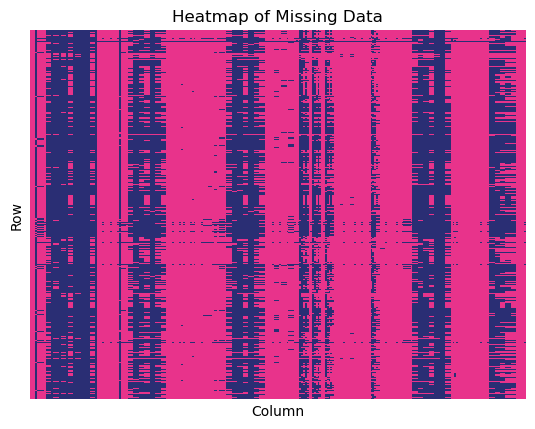

In [55]:
# Custom color map with teal and light purple (for style)
custom_cmap = ListedColormap(['#E8338B', '#2A2E74'])  # Pink and Purple
sns.heatmap(county_data.isnull(), cbar=False, cmap=custom_cmap)
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Heatmap of Missing Data')
plt.xticks([])
plt.yticks([])


This next graph gives an ordered view of how complete each column is. 

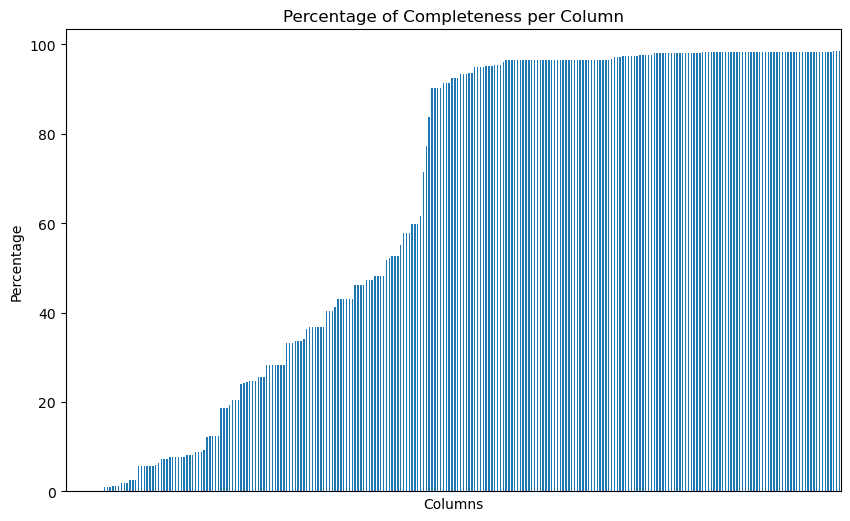

In [56]:
# Calculate the completeness of each column (# complete / total)
completeness = (county_data.notnull().sum() / len(sheet1)) * 100
# Order from smallest to largest, for visual effect
completeness = completeness.sort_values()

# Plot % completed
completeness.plot(kind='bar', figsize=(10,6))
plt.title('Percentage of Completeness per Column')
plt.ylabel('Percentage')
plt.xlabel('Columns')
# For our purpose we do not care about the specific column, just the overall visual
plt.xticks([])
plt.show()

In [57]:
completeness_90 = completeness[completeness >= 90]
print(f"There are {len(completeness_90)} columns with at least 90% of their data.Those columns are:")
for label in completeness_90.index:
    print(label)

There are 144 columns with at least 90% of their data.Those columns are:
Premature Death_95% CI - Low
Premature Death_Years of Potential Life Lost Rate
Premature Death_Deaths
Premature Death_95% CI - High
Teen Births_Teen Birth Rate
Teen Births_95% CI - Low
Teen Births_95% CI - High
Mental Health Providers_Mental Health Provider Ratio
Mental Health Providers_Mental Health Provider Rate
Mental Health Providers_# Mental Health Providers
Primary Care Physicians_Primary Care Physicians Rate
Primary Care Physicians_Primary Care Physicians Ratio
Primary Care Physicians_# Primary Care Physicians
Sexually Transmitted Infections_Chlamydia Rate
Sexually Transmitted Infections_# Chlamydia Cases
Injury Deaths_# Injury Deaths
Injury Deaths_95% CI - Low
Injury Deaths_95% CI - High
Injury Deaths_Injury Death Rate
Low Birthweight_% Low Birthweight
Low Birthweight_95% CI - High
Low Birthweight_95% CI - Low
Dentists_Dentist Rate
Dentists_Dentist Ratio
Dentists_# Dentists
Preventable Hospital Stays_Preve

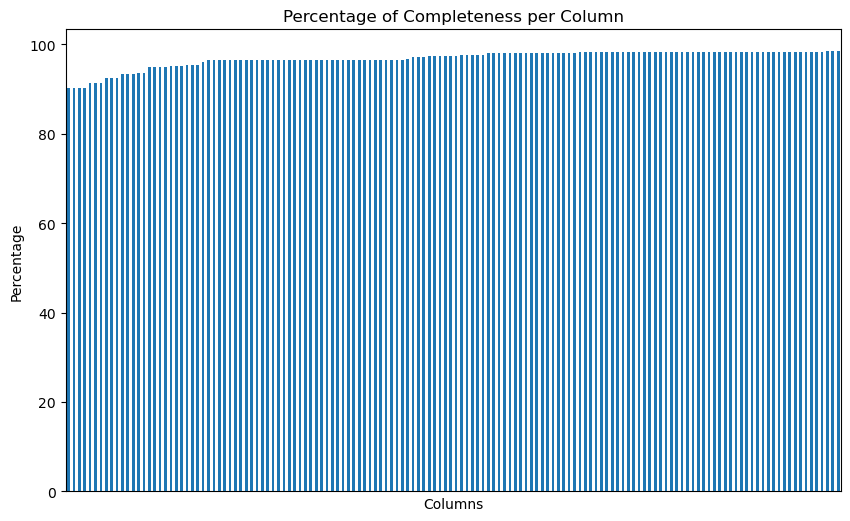

In [58]:

completeness_90.plot(kind='bar', figsize=(10,6))
plt.title('Percentage of Completeness per Column')
plt.ylabel('Percentage')
# Again, we do not care about the specific column names
plt.xticks([])
plt.xlabel('Columns')
plt.show()

So, we have a list of columns that have at least 90% of the data for. Recall, these 

In [59]:
# We can further streamline this list:
group_freq = {}
for name in completeness_90.index:
    first_group = name.split("# ")[-1].split('_')[0]
    if first_group not in group_freq.keys():
       group_freq[first_group] = 1
    else:
        group_freq[first_group] += 1

# make it so that the most frequent keys appear first
group_freq_sorted = {key: value for key, value in 
                     sorted(group_freq.items(), key=lambda item: item[1], 
                            reverse=True)}
print(f"We have {len(group_freq)} outer level categories with at least 90% fill rate in some category")
n = 1
for name, value in group_freq_sorted.items():
    print(f"{n}:\t{name}({value})")
    n += 1


We have 44 outer level categories with at least 90% fill rate in some category
1:	Severe Housing Problems(13)
2:	Some College(6)
3:	Premature Death(5)
4:	Injury Deaths(5)
5:	High School Completion(5)
6:	Children in Single-Parent Households(5)
7:	Alcohol-Impaired Driving Deaths(5)
8:	Uninsured(5)
9:	Teen Births(4)
10:	Mental Health Providers(4)
11:	Primary Care Physicians(4)
12:	Low Birthweight(4)
13:	Dentists(4)
14:	Driving Alone to Work(4)
15:	Income Inequality(4)
16:	Children in Poverty(4)
17:	Long Commute - Driving Alone(4)
18:	Poor or Fair Health(4)
19:	Excessive Drinking(4)
20:	Physical Inactivity(4)
21:	Poor Physical Health Days(4)
22:	Adult Obesity(4)
23:	Poor Mental Health Days(4)
24:	Adult Smoking(4)
25:	Unemployment(3)
26:	Sexually Transmitted Infections(2)
27:	Preventable Hospital Stays(2)
28:	Social Associations(2)
29:	Drinking Water Violations(2)
30:	Air Pollution - Particulate Matter(2)
31:	Access to Exercise Opportunities(2)
32:	Flu Vaccinations(2)
33:	Food Environment I

### Possible Good Categories
There are clearly plenty of things to choose from, but some of these seem like they will be relevant to our reasearch questions and interests.
1. County
2. Preventalbe Hospital Stays
3. Income Inequality
4. Uninsured
5. Adult Obesity
6. Access to Exercise Opportunities
7. Food Environment Index
8. Excessive Drinking
9. Primary Care Pysicians
10. Physical Inactivity

In [107]:
def topic_check(substring):
    # Check if there are any columns containing the substring
    filtered_columns = sheet1.filter(like=substring)
    
    # If no columns were found with the substring, print a message and return
    if filtered_columns.empty:
        print(f"No columns found containing '{substring}'")
        return
    
    # Calculate the percentage of non-null values for each filtered column
    non_null_percent = filtered_columns.notnull().sum() / len(filtered_columns) * 100
    
    # Print the results
    print(f"Columns containing '{substring}':")
    print(filtered_columns.columns)
    print("\nPercentage of non-null values for each column:")
    print(non_null_percent)

In [108]:
final_cols = ['FIPS','State','County','Adult Obesity_% Adults with Obesity', 
              'Adult Obesity_National Z-Score', 
              'Food Environment Index_Food Environment Index', 
              'Food Environment Index_National Z-Score',
              'Access to Exercise Opportunities_% With Access to Exercise Opportunities',
              'Access to Exercise Opportunities_National Z-Score',
              r'Excessive Drinking_% Excessive Drinking',
              'Excessive Drinking_National Z-Score',
              'Uninsured_# Uninsured', r'Uninsured_% Uninsured',
              'Uninsured_National Z-Score', 
              'Primary Care Physicians_Primary Care Physicians Rate',
              'Primary Care Physicians_National Z-Score',
              'Preventable Hospital Stays_Preventable Hospitalization Rate',
              'Preventable Hospital Stays_National Z-Score',
              'Income Inequality_80th Percentile Income',
              'Income Inequality_20th Percentile Income' ,
              'Income Inequality_Income Ratio', 
              'Income Inequality_National Z-Score',
              'Premature Death_Deaths',
              'Premature Death_Years of Potential Life Lost Rate',
              'Mental Health Providers_Mental Health Provider Ratio',
              'Mental Health Providers_Mental Health Provider Rate',
              'Mental Health Providers_# Mental Health Providers',
              'Severe Housing Problems_National Z-Score',
              'Unemployment_National Z-Score',
              'Physical Inactivity_National Z-Score',
              'Adult Smoking_National Z-Score',
              'Dentists_National Z-Score',
              'Mental Health Providers_National Z-Score',
              'Poor or Fair Health_National Z-Score',
              'Poor Physical Health Days_National Z-Score',
              'Poor Mental Health Days_National Z-Score',
              'Dentists_Dentist Ratio', 'Dentists_# Dentists',
              'Dentists_Dentist Rate',
              'Unemployment_# Unemployed',
              r'Unemployment_% Unemployed',
              'Poor Physical Health Days_Average Number of Physically Unhealthy Days',
              'Severe Housing Problems_Inadequate Facilities',
              'Severe Housing Problems_Overcrowding']

new_cols = ['fips','state','county','adult_obesity_pct','adult_obesity_z',
            'food_environment_index', 'food_environment_index_z', 
            'exercise_access_pct', 'exercise_access_z',
            'excess_drinking_pct', 'excess_drinking_z',
            'uninsured_num', 'uninsured_pct', 'uninsured_z',
            'primary_care_phys_rate', 'primary_care_phys_z',
            'prevent_hospital_rate', 'prevent_hospital_z', 
            'income_inequal_80pct', 'income_inequal_20pct',
            'income_inequal_ratio', 'income_inequal_z',
            'early_death_count', 'early_death_years_lost',
            'mental_health_ratio', 'mental_health_rate',
            'mental_health_num', 'housing_z', 'unemployment_z',
            'physical_inactive_z','smoking_z', 'dentists_z',
            'mental_health_z', 'poor_health_z', 'poor_phys_health_z',
            'poor_mental_health_z', 'dentists_ratio', 'dentists_num',
            'dentists_rate', 'unemployment_num', 
            'unemployment_pct', 'poor_physical_health_avg_days', 
            'housing_inad_facil', 'housing_overcrowding']

# Create the dictionary for renaming columns
new_cols_dict = dict(zip(final_cols, new_cols))

# Rename the columns in your DataFrame
final_cols_df = sheet1[final_cols]
final_cols_df = final_cols_df.rename(columns=new_cols_dict)

# Split state and county level data
final_cols_state = final_cols_df[final_cols_df['county'].isna()]
final_cols_county = final_cols_df[final_cols_df['county'].notna()]


## More Data Cleaning


In [109]:
state_completeness = final_cols_state.notna().sum()/51
state_completeness

fips                             1.0
state                            1.0
county                           0.0
adult_obesity_pct                1.0
adult_obesity_z                  0.0
food_environment_index           1.0
food_environment_index_z         0.0
exercise_access_pct              1.0
exercise_access_z                0.0
excess_drinking_pct              1.0
excess_drinking_z                0.0
uninsured_num                    1.0
uninsured_pct                    1.0
uninsured_z                      0.0
primary_care_phys_rate           1.0
primary_care_phys_z              0.0
prevent_hospital_rate            1.0
prevent_hospital_z               0.0
income_inequal_80pct             1.0
income_inequal_20pct             1.0
income_inequal_ratio             1.0
income_inequal_z                 0.0
early_death_count                1.0
early_death_years_lost           1.0
mental_health_ratio              1.0
mental_health_rate               1.0
mental_health_num                1.0
h

In [63]:
final_cols_state_no_na = final_cols_state.dropna(axis=1, how='all')
final_cols_state_no_na.head()

,fips,state,adult_obesity_pct,food_environment_index,exercise_access_pct,excess_drinking_pct,uninsured_num,uninsured_pct,primary_care_phys_rate,prevent_hospital_rate,...,mental_health_rate,mental_health_num,dentists_ratio,dentists_num,dentists_rate,unemployment_num,unemployment_pct,poor_physical_health_avg_days,housing_inad_facil,housing_overcrowding
0,1000,Alabama,40.6,5.4,61.333795,14.477526,469887.0,11.693351,63.65235,3280.0,...,135.09263,6855.0,2016:1,2517.0,49.60294,59363.0,2.596766,3.934735,0.856498,1.665074
68,2000,Alaska,33.4,7.0,78.230166,19.610502,80538.0,13.184298,96.76895,1866.0,...,722.75394,5302.0,954:1,769.0,104.82795,14401.0,4.036109,3.564454,4.222592,6.475948
104,4000,Arizona,31.8,6.9,85.470087,18.807308,758331.0,13.132044,66.44846,1962.0,...,182.01714,13395.0,1509:1,4876.0,66.25723,138129.0,3.820823,3.533107,1.171773,4.407342
120,5000,Arkansas,39.3,4.7,63.604208,15.417446,268334.0,11.055859,67.64950,3015.0,...,261.88282,7976.0,2044:1,1490.0,48.92244,45420.0,3.316846,4.332924,1.174239,2.776484
196,6000,California,27.8,8.6,94.229806,17.245677,2640001.0,8.066461,81.09520,2153.0,...,449.82311,175563.0,1076:1,36261.0,92.90702,811077.0,4.212955,3.116360,1.304156,8.209804


### Fixing FIPS Codes

FIPS codes are very specific. For counties they are a five digit string while states have two digit codes. We need to prepare the FIPS data for when we do our mapping.

In [64]:
# Ensure FIPS codes are strings and zero-padded to 5 digits for final_cols_county
final_cols_county['fips'] = final_cols_county['fips'].astype(str).str.zfill(5)

# Ensure FIPS codes are strings and zero-padded to 5 digits for final_cols_state_no_na
final_cols_state_no_na['fips'] = final_cols_state_no_na['fips'].astype(str).str.zfill(5)

# Extract the first two characters for state-level FIPS in final_cols_state_no_na
final_cols_state_no_na['fips'] = final_cols_state_no_na['fips'].str[:2]

# Check the resulting FIPS codes in final_cols_state_no_na
print(final_cols_state_no_na['fips'])

0       01
68      02
104     04
120     05
196     06
255     08
320     09
329     10
333     11
335     12
403     13
563     15
569     16
614     17
717     18
810     19
910     20
1016    21
1137    22
1202    23
1219    24
1244    25
1259    26
1343    27
1431    28
1514    29
1630    30
1687    31
1781    32
1799    33
1810    34
1832    35
1866    36
1929    37
2030    38
2084    39
2173    40
2251    41
2288    42
2356    44
2362    45
2409    46
2477    47
2573    48
2828    49
2858    50
2873    51
3008    53
3048    54
3104    55
3177    56
Name: fips, dtype: object


C:\Users\rosem\AppData\Local\Temp\ipykernel_17136\1630826615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_cols_county['fips'] = final_cols_county['fips'].astype(str).str.zfill(5)
C:\Users\rosem\AppData\Local\Temp\ipykernel_17136\1630826615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_cols_state_no_na['fips'] = final_cols_state_no_na['fips'].astype(str).str.zfill(5)
C:\Users\rosem\AppData\Local\Temp\ipykernel_17136\1630826615.py:8: SettingWithCopyWarning: 
A value is trying to be se

It seems like a good idea to see if the state columns behave differently than the county columns.

In [65]:
# Maybe states are different actually
state_summaries_all_info = sheet1[sheet1['County'].isna()]
state_summaries_all_info.head()

,FIPS,State,County,Premature Death_Unreliable,Premature Death_Deaths,Premature Death_Years of Potential Life Lost Rate,Premature Death_95% CI - Low,Premature Death_95% CI - High,Premature Death_National Z-Score,Premature Death_YPLL Rate (Hispanic (all races)),...,Driving Alone to Work_% Drive Alone (Hispanic) 95% CI - Low,Driving Alone to Work_% Drive Alone (Hispanic) 95% CI - High,Driving Alone to Work_% Drive Alone (White),Driving Alone to Work_% Drive Alone (White) 95% CI - Low,Driving Alone to Work_% Drive Alone (White) 95% CI - High,Long Commute - Driving Alone_# Workers who Drive Alone,Long Commute - Driving Alone_% Long Commute - Drives Alone,Long Commute - Driving Alone_95% CI - Low,Long Commute - Driving Alone_95% CI - High,Long Commute - Driving Alone_National Z-Score
0,1000,Alabama,NaN,NaN,98140.0,11415.734833,11307.652847,11523.816818,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2183677.0,35.2,34.770402,35.629598,NaN
68,2000,Alaska,NaN,NaN,9838.0,9414.775658,9158.406660,9671.144655,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,351067.0,17.5,16.640805,18.359195,NaN
104,4000,Arizona,NaN,NaN,104430.0,8865.491611,8785.896248,8945.086974,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3244419.0,36.0,35.570402,36.429598,NaN
120,5000,Arkansas,NaN,NaN,56311.0,10823.130850,10688.893693,10957.368007,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1304084.0,27.7,27.153991,28.246009,NaN
196,6000,California,NaN,NaN,420722.0,6373.194549,6345.303249,6401.085849,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18353469.0,41.6,41.361702,41.838298,NaN


First, we can look visually with another heatmap.

([], [])

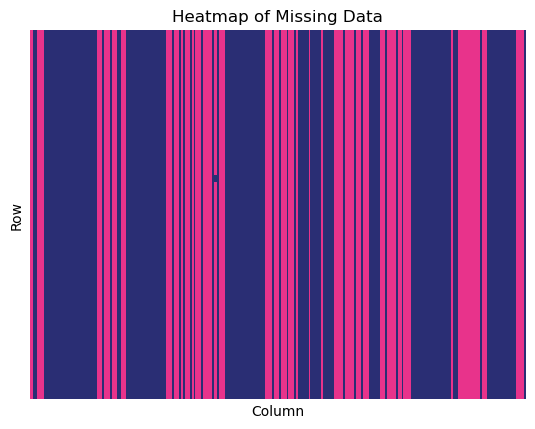

In [66]:
# Custom color map with pink and purple (for style)
custom_cmap = ListedColormap(['#E8338B', '#2A2E74'])  # Pink and Purple
sns.heatmap(state_summaries_all_info.isnull(), cbar=False, cmap=custom_cmap)
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Heatmap of Missing Data')
plt.xticks([])
plt.yticks([])


We can confirm that there is a lot of all or nothing values using `.value_counts()`.

In [67]:
state_summaries_completeness = state_summaries_all_info.isna().sum()/51*100
state_summaries_completeness.value_counts()

100.000000    164
0.000000      106
1.960784        2
Name: count, dtype: int64

In [68]:
# Remove Confidence Interval Cols that will not be used.
state_summaries_no_na = state_summaries_all_info.dropna(axis=1, how='all')
state_summaries_no_na.head()

print(f"There are {len(state_summaries_no_na.columns)} columns with all state info")

There are 108 columns with all state info


### FIPS Codes
* explain what FIPS is
* explain what the format is for states and counties

In [69]:
# Get FIPS type
type(final_cols_county['fips'][1])

str

### Shapefile data with geopandas

It would be cool to do a scatter plot with each location where size and color relate to some scale(s). To do that we need to find the "center" of each state and also county. We will do this using `geopandas`. 


In [70]:
# Load the shapefile for counties
shapefile_path_counties = 'Resources/US Counties Shape Data/c_05mr24.shp'
gdf_counties = gpd.read_file(shapefile_path_counties)

print(gdf_counties.head())

  STATE  CWA     COUNTYNAME   FIPS TIME_ZONE FE_AREA       LON      LAT  \
0    ME  CAR     Washington  23029         E      se  -67.6361  45.0363   
1    GA  CHS       McIntosh  13191         E      se  -81.2646  31.5329   
2    GA  CHS        Liberty  13179         E      se  -81.2103  31.7093   
3    AS  PPG  Swains Island  60040         S    None -171.0802 -11.0548   
4    AS  PPG         Manu'a  60020         S    None -169.5060 -14.2219   

                                            geometry  
0  MULTIPOLYGON (((-67.93539 44.40382, -67.93643 ...  
1  MULTIPOLYGON (((-81.46814 31.33980, -81.46747 ...  
2  POLYGON ((-81.30807 31.79454, -81.30546 31.791...  
3  POLYGON ((-171.07475 -11.05295, -171.07366 -11...  
4  MULTIPOLYGON (((-169.60973 -14.15779, -169.609...  


In [71]:
county_data_geo = final_cols_county.merge(gdf_counties[['FIPS', 'LON', 'LAT']], 
                                          left_on='fips', right_on='FIPS',
                                            how='left')

county_data_geo.rename
# Drop the added FIPS row
county_data_geo = county_data_geo.drop(columns=['FIPS'])
county_data_geo = county_data_geo.rename(columns={ 'LON': 'longitude', 'LAT': 'latitude'})
county_data_geo.head()

,fips,state,county,adult_obesity_pct,adult_obesity_z,food_environment_index,food_environment_index_z,exercise_access_pct,exercise_access_z,excess_drinking_pct,...,dentists_ratio,dentists_num,dentists_rate,unemployment_num,unemployment_pct,poor_physical_health_avg_days,housing_inad_facil,housing_overcrowding,longitude,latitude
0,01001,Alabama,Autauga,38.9,0.330217,6.7,0.734845,54.491965,0.326964,15.237822,...,3320:1,18.0,30.12099,608.0,2.269588,3.910265,1.576994,1.600186,-86.6428,32.5349
1,01003,Alabama,Baldwin,37.2,-0.043150,7.5,0.055569,63.129350,-0.052993,16.422564,...,2124:1,116.0,47.07124,2417.0,2.350047,3.730943,0.636564,1.522994,-87.7171,30.7278
2,01005,Alabama,Barbour,43.4,1.318543,6.0,1.329212,54.854696,0.311008,12.277198,...,3088:1,8.0,32.38080,335.0,4.065041,5.023488,0.536481,3.755365,-85.3932,31.8696
3,01007,Alabama,Bibb,39.6,0.483957,7.6,-0.029340,43.390302,0.815326,14.785821,...,4401:1,5.0,22.72211,219.0,2.509741,4.552795,1.997245,1.239669,-87.1264,32.9986
4,01009,Alabama,Blount,37.7,0.066664,7.7,-0.114250,41.355227,0.904848,14.946115,...,5951:1,10.0,16.80333,574.0,2.225151,4.246335,1.344023,1.810894,-86.5674,33.9809


In [72]:
# Load the shapefile for states
shapefile_path_state = 'Resources/US States Shape Data/cb_2018_us_state_5m.shp'
gdf_state = gpd.read_file(shapefile_path_state)

print(gdf_state.head())

  STATEFP   STATENS     AFFGEOID GEOID STUSPS          NAME LSAD  \
0      31  01779792  0400000US31    31     NE      Nebraska   00   
1      53  01779804  0400000US53    53     WA    Washington   00   
2      35  00897535  0400000US35    35     NM    New Mexico   00   
3      46  01785534  0400000US46    46     SD  South Dakota   00   
4      48  01779801  0400000US48    48     TX         Texas   00   

          ALAND       AWATER  \
0  198956658395   1371829134   
1  172112588220  12559278850   
2  314196306401    728776523   
3  196346981786   3382720225   
4  676653171537  19006305260   

                                            geometry  
0  POLYGON ((-104.05351 41.15726, -104.05267 41.2...  
1  MULTIPOLYGON (((-122.32834 48.02134, -122.3217...  
2  POLYGON ((-109.05017 31.48000, -109.04984 31.4...  
3  POLYGON ((-104.05770 44.99743, -104.05021 44.9...  
4  POLYGON ((-106.64548 31.89867, -106.64084 31.9...  


We need to find the centroid of each state. Unfortunately, we cannot just use `gdf_state.geometry.centroid` but instead must reproject to a projected CRS. This is due to global coordinate systems discussing where data is located on earth's surface while a projected coordinate system is discussing data on a flat surface. [Here is a brief article explaining](https://www.esri.com/arcgis-blog/products/arcgis-pro/mapping/gcs_vs_pcs/).

In [73]:
# Reproject to a a projected coord system. Here we will sue ESPG:3395 - World Mercator
gdf_state_projected = gdf_state.to_crs(epsg=3395)

# Calculate centroids in new geometry
gdf_state_projected['centroid'] = gdf_state_projected.geometry.centroid

# Reproject back to WGS84 (ESPG:4326) for coordinates 
gdf_state_projected = gdf_state_projected.to_crs(epsg=4326)

# extract lat and lng from centroid 
gdf_state_projected['longitude'] = gdf_state_projected.centroid.x
gdf_state_projected['latitude'] = gdf_state_projected.centroid.y

# display the GeoDataFrame with centroids
print(gdf_state_projected[['centroid','longitude','latitude']].head())

                            centroid   longitude   latitude
0  POINT (-11111784.848 5064481.375)  -99.810850  41.527150
1  POINT (-13408196.057 5976964.996) -120.450862  47.382282
2  POINT (-11811701.547 4066810.755) -106.108377  34.421363
3  POINT (-11157800.088 5506262.721) -100.230451  44.436132
4  POINT (-11061168.730 3683426.477)  -99.349399  31.482594


C:\Users\rosem\AppData\Local\Temp\ipykernel_17136\396189455.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_state_projected['longitude'] = gdf_state_projected.centroid.x
C:\Users\rosem\AppData\Local\Temp\ipykernel_17136\396189455.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_state_projected['latitude'] = gdf_state_projected.centroid.y


In [74]:
gdf_state_projected.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,centroid,longitude,latitude
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05351 41.15726, -104.05267 41.2...",POINT (-11111784.848 5064481.375),-99.810850,41.527150
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.32834 48.02134, -122.3217...",POINT (-13408196.057 5976964.996),-120.450862,47.382282
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.05018 31.48000, -109.04985 31.4...",POINT (-11811701.547 4066810.755),-106.108377,34.421363
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.05770 44.99743, -104.05021 44.9...",POINT (-11157800.088 5506262.721),-100.230451,44.436132
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.64548 31.89867, -106.64084 31.9...",POINT (-11061168.730 3683426.477),-99.349399,31.482594


In [75]:
state_data_geo = final_cols_state_no_na.merge(gdf_state_projected[['GEOID', 'longitude', 'latitude']], 
                                          left_on='fips', right_on='GEOID',
                                            how='left')

# Drop the added FIPS row
state_data_geo = state_data_geo.drop(columns=['GEOID'])
state_data_geo.head()

,fips,state,adult_obesity_pct,food_environment_index,exercise_access_pct,excess_drinking_pct,uninsured_num,uninsured_pct,primary_care_phys_rate,prevent_hospital_rate,...,dentists_ratio,dentists_num,dentists_rate,unemployment_num,unemployment_pct,poor_physical_health_avg_days,housing_inad_facil,housing_overcrowding,longitude,latitude
0,01,Alabama,40.6,5.4,61.333795,14.477526,469887.0,11.693351,63.65235,3280.0,...,2016:1,2517.0,49.60294,59363.0,2.596766,3.934735,0.856498,1.665074,-86.828775,32.788820
1,02,Alaska,33.4,7.0,78.230166,19.610502,80538.0,13.184298,96.76895,1866.0,...,954:1,769.0,104.82795,14401.0,4.036109,3.564454,4.222592,6.475948,-152.211614,64.198645
2,04,Arizona,31.8,6.9,85.470087,18.807308,758331.0,13.132044,66.44846,1962.0,...,1509:1,4876.0,66.25723,138129.0,3.820823,3.533107,1.171773,4.407342,-111.664639,34.293214
3,05,Arkansas,39.3,4.7,63.604208,15.417446,268334.0,11.055859,67.64950,3015.0,...,2044:1,1490.0,48.92244,45420.0,3.316846,4.332924,1.174239,2.776484,-92.439064,34.899868
4,06,California,27.8,8.6,94.229806,17.245677,2640001.0,8.066461,81.09520,2153.0,...,1076:1,36261.0,92.90702,811077.0,4.212955,3.116360,1.304156,8.209804,-119.610560,37.245955


## US Census API
We are using the [United States Census API](https://www.census.gov/data/developers/data-sets.html) specifically the American Community Survey 1-Year Data from 2023. We will be getting the county population (code `B01003_001E`) and median household income (code `b19013_001E`). We then will merge these columns with the state and county dataframes. 


In [105]:
# County Data Management

# get base URL and params for county sample
url = 'https://api.census.gov/data/2020/acs/acs5'
params = {
    'get': 'NAME,B01003_001E,B19013_001E',
    'for': 'county:*',
    'in': 'state:*',
    'key': census_api_key
}

# make the request
response = requests.get(url, params=params)

# check that we have the desired response
if response.status_code == 200:
    # create a pandas DataFrame
    data = response.json()
    columns = data[0]
    data_rows = data[1:]
    census_data = pd.DataFrame(data_rows, columns=columns)

    # rename columns
    census_data = census_data.rename(columns={
         'NAME': 'county',
        'B01003_001E': 'population',
        'B19013_001E': 'median_income',
        'state': 'state_fips',
        'county': 'county_fips'
    })

# Ensure FIPS codes are strings and properly concatenated
census_data['fips'] = census_data['state_fips'].astype(str).str.zfill(2) + census_data['county_fips'].astype(str).str.zfill(3)

# Merge based on the FIPS code and specify suffixes to avoid conflicts
county_census_data_df = county_data_geo.merge(census_data[['fips', 'population', 'median_income']], 
                            on='fips',
                            how='left', suffixes=('_left', '_right'))

# Display the merged DataFrame
county_census_data_df.head()


,fips,state,county,adult_obesity_pct,adult_obesity_z,food_environment_index,food_environment_index_z,exercise_access_pct,exercise_access_z,excess_drinking_pct,...,dentists_rate,unemployment_num,unemployment_pct,poor_physical_health_avg_days,housing_inad_facil,housing_overcrowding,longitude,latitude,population,median_income
0,01001,Alabama,Autauga,38.9,0.330217,6.7,0.734845,54.491965,0.326964,15.237822,...,30.12099,608.0,2.269588,3.910265,1.576994,1.600186,-86.6428,32.5349,55639,57982
1,01003,Alabama,Baldwin,37.2,-0.043150,7.5,0.055569,63.129350,-0.052993,16.422564,...,47.07124,2417.0,2.350047,3.730943,0.636564,1.522994,-87.7171,30.7278,218289,61756
2,01005,Alabama,Barbour,43.4,1.318543,6.0,1.329212,54.854696,0.311008,12.277198,...,32.38080,335.0,4.065041,5.023488,0.536481,3.755365,-85.3932,31.8696,25026,34990
3,01007,Alabama,Bibb,39.6,0.483957,7.6,-0.029340,43.390302,0.815326,14.785821,...,22.72211,219.0,2.509741,4.552795,1.997245,1.239669,-87.1264,32.9986,22374,51721
4,01009,Alabama,Blount,37.7,0.066664,7.7,-0.114250,41.355227,0.904848,14.946115,...,16.80333,574.0,2.225151,4.246335,1.344023,1.810894,-86.5674,33.9809,57755,48922


In [103]:
# County Data Management

# get base URL and params for county sample
url = 'https://api.census.gov/data/2020/acs/acs5'
params = {
    'get': 'NAME,B01003_001E,B19013_001E',
    'for': 'state:*',
    'key': census_api_key
}

# make the request
response = requests.get(url, params=params)
# check that we have the desired response
if response.status_code == 200:
    # create a pandas DataFrame
    data = response.json()
    columns = data[0]
    data_rows = data[1:]
    census_data = pd.DataFrame(data_rows, columns=columns)

    # rename columns
    census_data = census_data.rename(columns={
         'NAME': 'state',
        'B01003_001E': 'population',
        'B19013_001E': 'median_income',
        'state': 'fips'
    })
census_data

# # Merge based on the FIPS code and specify suffixes to avoid conflicts
state_census_data_df = state_data_geo.merge(census_data[['fips', 'population', 'median_income']], 
                            on='fips', 
                            how='left', suffixes=('_left', '_right'))


# # Display the merged DataFrame
state_census_data_df.head()


,fips,state,adult_obesity_pct,food_environment_index,exercise_access_pct,excess_drinking_pct,uninsured_num,uninsured_pct,primary_care_phys_rate,prevent_hospital_rate,...,dentists_rate,unemployment_num,unemployment_pct,poor_physical_health_avg_days,housing_inad_facil,housing_overcrowding,longitude,latitude,population,median_income
0,01,Alabama,40.6,5.4,61.333795,14.477526,469887.0,11.693351,63.65235,3280.0,...,49.60294,59363.0,2.596766,3.934735,0.856498,1.665074,-86.828775,32.788820,4893186,52035
1,02,Alaska,33.4,7.0,78.230166,19.610502,80538.0,13.184298,96.76895,1866.0,...,104.82795,14401.0,4.036109,3.564454,4.222592,6.475948,-152.211614,64.198645,736990,77790
2,04,Arizona,31.8,6.9,85.470087,18.807308,758331.0,13.132044,66.44846,1962.0,...,66.25723,138129.0,3.820823,3.533107,1.171773,4.407342,-111.664639,34.293214,7174064,61529
3,05,Arkansas,39.3,4.7,63.604208,15.417446,268334.0,11.055859,67.64950,3015.0,...,48.92244,45420.0,3.316846,4.332924,1.174239,2.776484,-92.439064,34.899868,3011873,49475
4,06,California,27.8,8.6,94.229806,17.245677,2640001.0,8.066461,81.09520,2153.0,...,92.90702,811077.0,4.212955,3.116360,1.304156,8.209804,-119.610560,37.245955,39346023,78672


## Last Bit - Export to a CSV

Ideally we will choose a relevent subset of columns, rename them to something manageable, and then save them to a `.csv` file in the `resources` folder.

In [106]:
# Write to CSV
county_census_data_df.to_csv('Resources/county_data.csv', index=False)
state_census_data_df.to_csv('Resources/state_data.csv', index=False)